# Introduction

Our group's selected paper is [HiCu: Leveraging Hierarchy for Curriculum Learning in Automated ICD Coding](https://arxiv.org/abs/2208.02301), published to arXiv in 2022 by Ren et. al.

Visit the [Project GitHub Repository](https://github.com/rajdtta/HiCu-ICD) to download the necessary files & view instructions on getting your local environment setup.

A link to the video can be found [here](https://www.youtube.com/watch?v=qWyUKBkgWi4&ab_channel=MilesCheng).

## The Problem

This paper aims to address the challenge of **multi-label classification** within the healthcare industry, specifically in the context of assigning ICD-9 codes to medical documents using Machine Learning models.

ICD codes are generally assigned from a patients' discharge summaries, after which they can be used for billing, research, and epidemiological studies. This coding is traditionally done by professional clinical coders, making the process time and labor intensive on top of being susceptible to human errors.

Automating this process using machine learning techniques can free up a substantial amount of resources that may be better utilized elsewhere, making automated label classification a common focus area amongst ML researchers in the healthcare industry.

Multi-label classification in healthcare has traditionally been quite challenging due to the requirements of high accuracy across multiple label combinations, as well as the ability to retain knowledge of rare labels even in the presence of an overwhelming amount of commonalities.


Some examples of state-of-the-art methods (at the time of the paper's publication) include:

- CAML (Mullenbach et. al., 2018) - An architecture using one convolution layer and one "per-label" attention layer.
- DR-CAML - An extension of CAML that regularizes the model using the text description of each code
- MSATT-KG (Xie et. al., 2019) - Architecture composing adense combolutional layer & a multi-scale feature attention layer. Hierarchical information among labels is captured during prediction using a graph CNN (Kipf and Welling, 2016).
- HyperCore (Cao et. al., 2020) - An architecture using a hyperbolic embedding layer to leverage the inherent coding hierarchy, as well as a graph CNN to utilize the code co-occurances.
- JointLAAT - An extension of LAAT (Vu et. al., 2020) with a hierarchical joint learning mechanism.

---

## The Paper

In their paper *HiCu: Leveraging Hierarchy for Curriculum Learning in Automated ICD Coding*, Ren et. al. proposes a novel Hierarchical Curriculum ("HiCu") algorithm.

> **Curriculum learning** is the process of training a model on increasingly difficult tasks within the problem domain, starting with the easiet subset of tasks. Using math as an example, the levels of curriculum could start with basic arithmetic (i.e. addition/subtraction), and slowly scale up into more challenging tasks such as derivatives and integrals.

The authors hypothesize that this algorithm, which builds upon previous work published by researchers such as Zhang et. al. (2019), Cao et. al. (2020), Vu et. al. (2020), and Kim and Ganapathi (2021), can lead to increased classification accuracy due to its utilization of hierarchical knowledge, hyperbolic embeddings, and automated ICD coding when architecting the encoder-decoder classifier.

### Innovations

The HiCu algorithm "creates a curriculum for learning based on a depth-wise decomposition of the label graph and a hyperbolic-embedding-based knowledge
transfer mechanism to warm start
representations from one step of curriculum learning to the next." (Ren et. al., 2022) In order to combat the highly imbalanced label distribution, they incorporate an asymmetric loss function to help balance the performance on common & rare labels.

![Diagram](https://i.raj.wtf/imgs/Yp7bjdeuGjFHibpdvr9JWEV4fTu.png)
<center>Figure 1: A diagram from the original paper explaining how the HiCu algorithm works (Ren et. al., 2022)</center>

### Evaluation & Results

![Evaluation](https://i.raj.wtf/imgs/vRrFUao7gb0A7VOZ8CUUVK0yygX.png)

<center>Figure 2: A table from the original paper showing the evaluation results of the HiCu algorithm compared to various baseline models/approaches (Ren et. al., 2022)</center>

The model was evaluated by comparing AUC, F1, & Precision @ K between the HiCu models and several baseline models. The authors found that the HiCu algorithm "improves generalization across all metrics, over convolution, recurrent, and transformer-based neural networks." (Ren et. al., 2022)

### Impact

Given that the paper's findings supported the original hypothesis of improved performance over the then-current state-of-the-art approaches, the HiCu algorithm established a new standard for multi-label classification in the healthcare industry.


# Scope of Reproducibility

The original models were seemingly trained on the cloud using enterprise-level hardware (due to how compute-intensive the training process is). Without any changes, the estimated training time using our available resources would be in the hundreds of hours *per model* (with there being 11 models trained in the original paper). As a result, we impose the following restrictions:

1. Only 5% of the original dataset will be used
2. Instead of training 11 different models, we will only be training 3 models (the base MultiResCNN model, the MultiResCNN model with the HiCu algorithm, and the MultiResCNN model with the HiCu algorithm and asymmetric loss)
3. At the last level of depth (`n=5`), the model will be trained for 50 epochs instead of 500. The resulting number of epochs per depth level is `[2, 3, 5, 10, 50]`.

---

We will be testing the general hypothesis that the HiCu algorithm provides superior multi-label classification performance compared to (the then-current) state-of-the-art approaches. In our case, we will be comparing the base MultiResCNN model with a variant that uses the HiCu algorithm. As an ablation study, we will evaluate whether the addition of the asymmetric loss function on top of the HiCu algorithm improves classification performance.

# Methodology

## Requirements

Follow the README in the [Project GitHub Repository](https://github.com/rajdtta/HiCu-ICD) to get your environment set up.

### Python Environment

Recommended Version: Python `3.11.7`

#### Packages (`requirements.txt`)

```
gensim==4.3.2
nltk==3.8.1
numpy==1.26.4
pandas==2.2.1
scikit-learn==1.4.1.post1
scipy==1.12.0
torch==2.2.1
tqdm==4.66.2
transformers==4.38.2
```

### Compute Environment

For training, we used a 64-bit operating system, x64-based processor Windows instance running:

- CPU: AMD Ryzen 7 7735HS
- RAM: 64 GB
- GPU: NVIDIA RTX 3050
- Storage: 2 TB

Apple Silicon machines are also supported, but may result in longer training times due to the lack of CUDA support.

In [ ]:
# Import required libraries
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

# Download punkt from NLTK (used for preprocessing + training)
nltk.download('punkt')

##  Data

This paper uses the [MIMIC-III v1.4 dataset](https://physionet.org/content/mimiciii/1.4/).

### Data Access

In order to access the raw files, you must: (1) be a credentialed (verified) user on [PhysioNet](https://physionet.org), (2) sign the [data use agreement](https://physionet.org/login/?next=/sign-dua/mimiciii/1.4/), and (3) complete the [CITI Data or Speciments Only Research](https://physionet.org/content/mimiciii/view-required-training/1.4/#1) course.

### Directory Structure

In order to run the preprocessing & training scripts, the original dataset must be in the following directory structure:

```
HiCu-ICD/ (project root)
|
... (other files in the repository)
└── data/
|   |   D_ICD_DIAGNOSES.csv
|   |   D_ICD_PROCEDURES.csv
|   └───mimic3/
|   |   |   NOTEEVENTS.csv
|   |   |   DIAGNOSES_ICD.csv
|   |   |   PROCEDURES_ICD.csv
|   |   |   train_full_hadm_ids.csv
|   |   |   train_50_hadm_ids.csv
|   |   |   dev_full_hadm_ids.csv
|   |   |   dev_50_hadm_ids.csv
|   |   |   test_full_hadm_ids.csv
|   |   |   test_50_hadm_ids.csv
```

The `*_hadm_ids.csv` files can be downloaded using the [following link](https://github.com/jamesmullenbach/caml-mimic/tree/master/mimicdata/mimic3).

Please follow the instructions in the `README.md` file of the [Project GitHub Repository](https://github.com/rajdtta/HiCu-ICD) to ensure that all the files are structured properly.

### Sampling & Preprocessing

Due to the constraints laid out in [Scope of Reproducibility](#scope-of-reproducibility), we will be using a 5% sample of the original dataset to cut down on compute & training time.

Following the original paper, we use the same preprocessing code used by the MultiResCNN paper (Li and Yu, 2020; Mullenbach et. al., 2018). Afterwards, word embeddings on the discharge summaries from the MIMIC-III dataset are pretrained using the Word2Vec CBOW method (Mikolov et. al., 2013).


In [ ]:
def load_and_preprocess_data(ratio=0.05):
  """
  Run this function if you want to load the raw dataset & run the preprocessing script (takes ~5m with a 5% ratio)
  :param ratio: The sampling ratio of the original dataset (default is 5%)
  """
  !python preprocess_mimic3.py --ratio {ratio}

load_and_preprocess_data()

In [ ]:
def load_preprocessed_data():
  return pd.read_csv('./data/mimic3/NOTEEVENTS_SAMPLED.csv', dtype={
    'ROW_ID': str,
    'SUBJECT_ID': str,
    'HADM_ID': str,
    'CHARTDATE': str,
    'CHARTTIME': str,
    'STORETIME': str,
    'CATEGORY': str,
    'DESCRIPTION': str,
    'CGID': str,
    'ISERROR': str,
    'TEXT': str
  })

def show_descriptive_stats(data: pd.DataFrame):
  """
  Shows various descriptive statistics about the dataset
  1. Number of rows & columns
  2. Column names
  3. Sample data
  4. The average number of events per subject_id
  """
  # Calculate statistics
  num_rows = len(data)
  num_columns = len(data.columns)
  column_names = data.columns.tolist()

  print(f'Number of rows: {num_rows}\nNumber of columns: {num_columns}\nColumn names: {column_names}\n')

  print(f'Sample Data:\n\n{data.head()}\n')

  # Get the average number of entries per subject_id
  avg_events_per_subject = data.groupby('SUBJECT_ID').size().mean()
  print(f'Average number of events per subject_id: {avg_events_per_subject}\n')

data = load_preprocessed_data()
show_descriptive_stats(data)

In [ ]:
def plot_category_distribution(data: pd.DataFrame):
  # Show a bar plot of the category distribution
    category_grouped = data.groupby('CATEGORY').size().reset_index(name='COUNT')
    print(f'Category Distribution of Events:\n\n{category_grouped}\n')

    category_grouped.plot(kind='bar', x='CATEGORY', y='COUNT', title='Category Distribution of Events', xlabel='Category', ylabel='Count')

plot_category_distribution(data)


## Models

For the purposes of this project, we will be training 3 different models:

<center>
Table 1: Description of Models
</center>
<table>
  <tr>
    <th></th>
    <th>MultiResCNN</th>
    <th>MultiResCNN w/ HiCuA</th>
    <th>MultiResCNN w/ HiCuA + ASL</th>
  </tr>
  <tr>
    <th>Description</th>
    <td>A vanilla MultiResCNN model</td>
    <td>The MultiResCNN model using the HiCu algorithm for the decoder</td>
    <td>
      The MultiResCNN model using the HiCu algorithm for the decoder and
      asymmetric loss for the loss function
    </td>
  </tr>
  <tr>
    <th>Pretrained? (<i>i.e.</i> foundation model)</th>
    <td>No</td>
    <td>No</td>
    <td>No</td>
  </tr>
  <tr>
    <th>Hyperparameters</th>
    <td>
      Batch Size: 8 <br />
      Learning Rate: 5e-5 <br />
      Hyperbolic Dimension: 50 <br />
    </td>
    <td>
      Batch Size: 8 <br />
      Learning Rate: 5e-5 <br />
      Hyperbolic Dimension: 50 <br />
    </td>
    <td>
      Batch Size: 8 <br />
      Learning Rate: 5e-5 <br />
      Hyperbolic Dimension: 50 <br />
    </td>
  </tr>
  <tr>
    <th>Decoder</th>
    <td><code>RandomlyInitialized</code></td>
    <td><code>HiCu</code></td>
    <td><code>HiCu</code></td>
  </tr>
  <tr>
    <th>Loss Function</th>
    <td>BCE w/ Logits</td>
    <td>BCE w/ Logits</td>
    <td>Asymmetric Loss</td>
  </tr>
  <tr>
    <th>Epochs (depth=5)</th>
    <td>[2,3,5,10,50]</td>
    <td>[2,3,5,10,50]</td>
    <td>[2,3,5,10,50]</td>
  </tr>
</table>


### Sample Training Run

The function below initiates a sample training run on the base MultiResCNN model. The `run_multirescnn_sample` script is a modified version of `run_multirescnn` that only trains the model for a single epoch and a single level of depth.

```bash
# run_multirescnn_sample.sh
python3 main.py \
    --MODEL_DIR /content/models \
    --DATA_DIR /content/data \
    --MIMIC_3_DIR /content/data/mimic3 \
    --data_path /content/data/mimic3/train_full.csv \
    --embed_file /content/data/mimic3/processed_full_100.embed \
    --vocab /content/data/mimic3/vocab.csv \
    --Y full \
    --model MultiResCNN \
    --decoder RandomlyInitialized \
    --criterion prec_at_8 \
    --MAX_LENGTH 4096 \
    --batch_size 8  \
    --lr 5e-5 \
    --num_workers 8 \
    --n_epochs '1,1,1,1,1'  \ # For actual training this would be '2,3,5,10,50'

```

In [ ]:
def train_sample_epoch():
  !chmod +x ./runs/run_multirescnn_sample.sh
  !./runs/run_multirescnn_sample.sh

# Uncomment to run, takes several minutes.
# train_sample_epoch()

### Pretrained Models

The pretrained models are available in the `./results` directory. The models are saved in the `.pth` format, and the training metrics are saved in the `metrics.json` file.

<center>
Table 2: Training Metrics
</center>
<table>
  <tr>
    <th></th>
    <th>MultiResCNN</th>
    <th>MultiResCNN w/ HiCuA</th>
    <th>MultiResCNN w/ HiCuA + ASL</th>
  </tr>
  <tr>
    <th>Hardware</th>
    <td>NVIDIA RTX 4050</td>
    <td>NVIDIA RTX 4050</td>
    <td>NVIDIA RTX 4050</td>
  </tr>
  <tr>
    <th>Epochs (depth=5)</th>
    <td>[2,3,5,10,50]</td>
    <td>[2,3,5,10,50]</td>
    <td>[2,3,5,10,50]</td>
  </tr>
  <tr>
    <th>Avg Time per Epoch</th>
    <td>~4m28s</td>
    <td>~6m18s</td>
    <td>~5m32s</td>
  </tr>
  <tr>
    <th>GPU Time Used</th>
    <td>268 min</td>
    <td>378 min</td>
    <td>332 min</td>
  </tr>
</table>

## Evaluation

At the end of each epoch, the model's performance is evaluated using the following metrics:

1. Macro/Micro AUC
2. Macro/Micro F1
3. Macro/Micro Precision
4. Macro/Micro Recall
5. Precision @ 5, 8, 15
6. Loss

The metrics are saved in a `metrics.json` file in the `./models` directory (along with the best model parameters), but we have provided pre-trained models in the `./results` directory to prevent conflicts.

In [ ]:
def load_pretrained_model_results(name):
  """
  Creates a Pandas dataframe containing various training metrics at each timestep (at the final depth = 50 epochs)
  """
  _metrics_file_path = f'./results/{name}/metrics.json'
  _data = None
  with open(_metrics_file_path, "r") as f:
    _data = json.loads(f.read())

  # The desired metrics (micro/macro accuracy/precision/recall/f1/auc (optionally @k), as well as training loss)
  _keys = ['acc_macro', 'prec_macro', 'rec_macro', 'f1_macro', 'acc_micro', 'prec_micro', 'rec_micro', 'f1_micro',
           'rec_at_5', 'prec_at_5', 'f1_at_5', 'rec_at_8', 'prec_at_8', 'f1_at_8', 'rec_at_15', 'prec_at_15',
           'f1_at_15', 'auc_macro', 'auc_micro', 'loss_tr']

  # Filter data to just the desired metrics
  _filtered_data = {key: _data[key] for key in _keys if key in _data}

  # Create a dataframe
  _df = pd.DataFrame.from_dict(_filtered_data)

  return _df


# Retrieve
baseline_results = load_pretrained_model_results('multirescnn')
hicua_results = load_pretrained_model_results('multirescnn_hicua')
hicua_asl_results = load_pretrained_model_results('multirescnn_hicua_asl')

# Show sample results
baseline_results.head()

# Results

In [ ]:
print(f'Baseline MultiResCNN Results:\n\n{baseline_results.iloc[-1]}\n')

In [ ]:
print(f'MultiResCNN w/ HiCuA Results:\n\n{hicua_results.iloc[-1]}\n')

In [ ]:
print(f'MultiResCNN w/ HiCuA & ASL Results:\n\n{hicua_asl_results.iloc[-1]}\n')

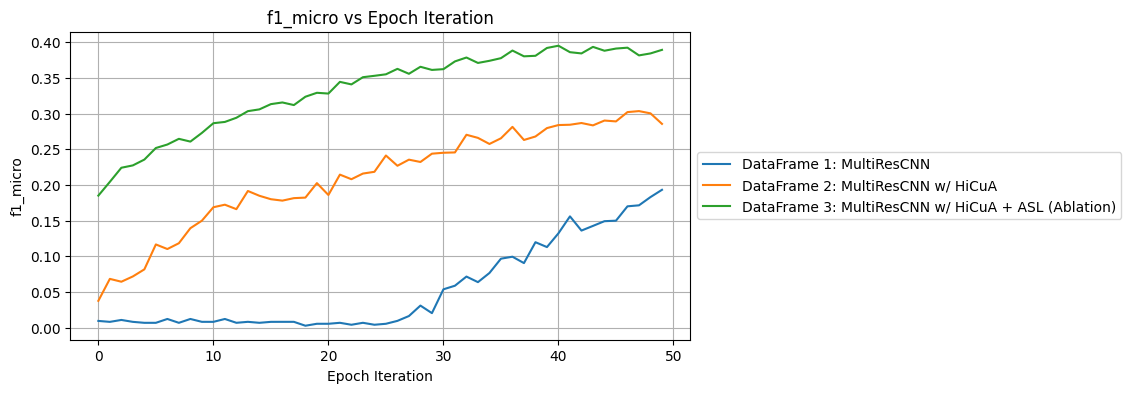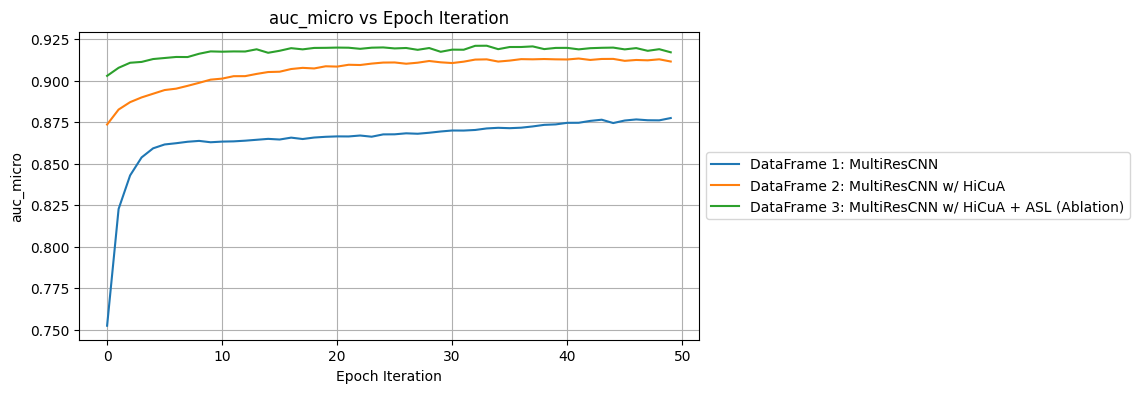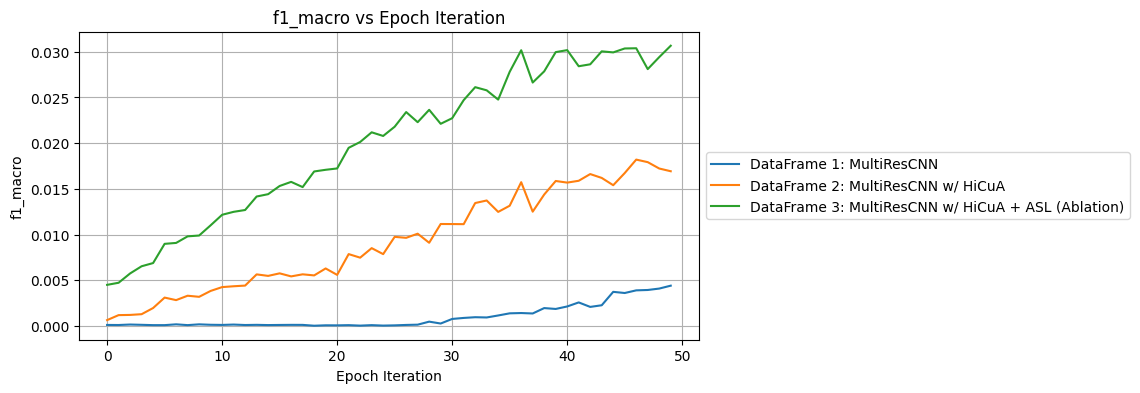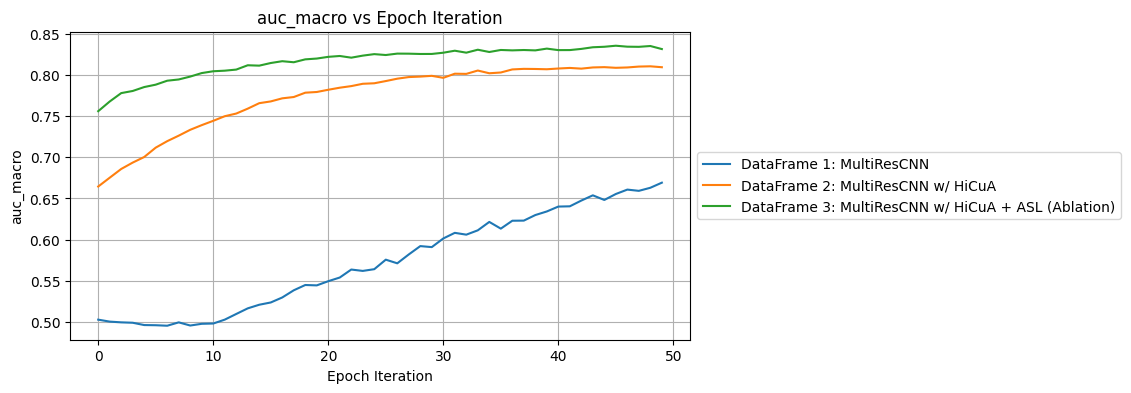

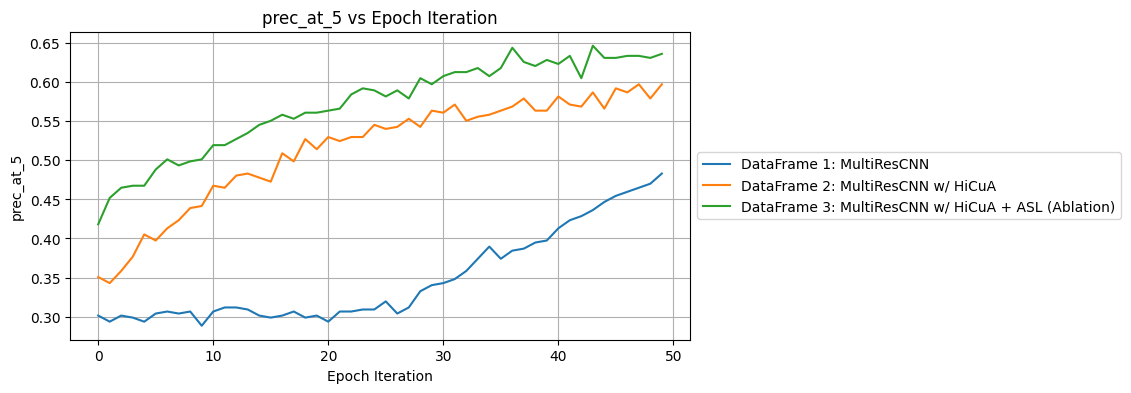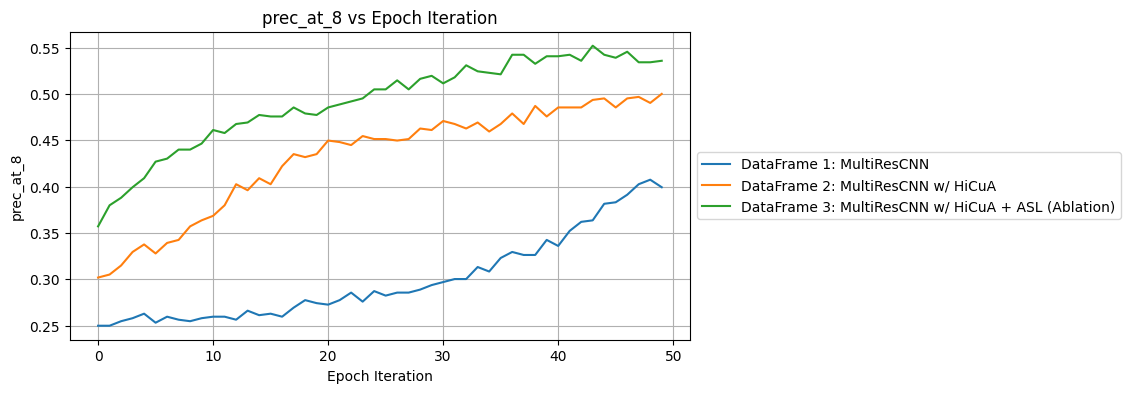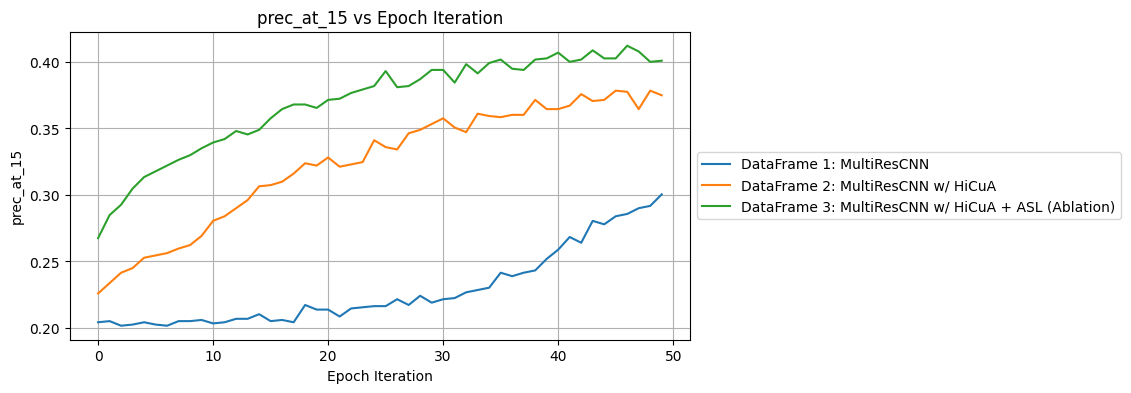

<center>
Table 3: Comparison between Baseline MultiResCNN, MultiResCNN w/ HiCuA, and MultiResCNN w/ HiCuA & ASL
</center>

| Model                                 | AUC (Macro) | AUC (Micro) | F1 (Macro) | F1 (Micro) | Precision @ 5 | Precision @ 8 | Precision @ 15 |
|---------------------------------------|-------------|-------------|------------|------------|---------------|---------------|----------------|
| MultiResCNN                           | 66.92       | 87.76       | 0.44       | 19.33      | 48.31         | 39.94         | 30.04          |
| MultiResCNN w/ HiCuA                  | 80.92       | 91.16       | 1.69       | 28.57      | 59.74         | 50.00         | 37.49          |
| MultiResCNN w/ HiCuA & ASL (Ablation) | 83.12       | 91.72       | 3.07       | 38.95      | 63.64         | 53.57         | 40.09          |

The results from our experiments demonstrate that the MultiResCNN model enhanced with the HiCuA algorithm and the asymmetric loss function (ASL) achieved superior performance compared to the baseline MultiResCNN model and the MultiResCNN model with HiCuA alone across various evaluation metrics, including AUC Macro, AUC Micro, F1 Macro, F1 Micro, Precision@5, Precision@8, and Precision@15. The visualizations above provide a visual comparison of the various evaluation metrics across all 3 trained models.

Our results align with the original paper's hypothesis that the HiCu algorithm improves classification performance compared to the (then-current) state-of-the-art processes such as the baseline MultiResCNN model. The inclusion of curriculum learning alone already led to improvements, and further enhancements were observed when the asymmetric loss function was introduced as part of our ablation study. This suggests that the curriculum learning approach employed by the HiCu algorithm effectively guides the training process, allowing the models to learn more efficiently and generalize better to unseen data.

Even though our experiments were limited in terms of available computational resources and training data compared to the original paper (using consumer-grade hardware and a 5% sample of the original dataset), our results still support the original paper's findings. We believe that, with sufficient computational resources, it would be feasible to train models to achieve similar levels of performance as reported in the original paper. This underscores the importance of considering both the algorithmic techniques and the computational resources available when designing and evaluating machine learning models for complex tasks like multi-label classification in healthcare scenarios.


## Ablation Study

We conducted a similar ablation study to the original paper, which extends the HiCu algorithm by incorporating asymmetric loss (ASL) to determine whether it provides superior performance of the baseline MultiResCNN model and/or the MultiResCNN model w/ HiCuA. This involved training a third model, using the same constraints laid out in (Scope of Reproducibility)[#scope-of-reproducibility] to ensure that the only difference between the models is their architecture.

Given the results in Table 3, we can see that the usage of the asymmetric loss function (ASL) in conjunction with the HiCuA algorithm led to further improvements in the model's performance across all evaluation metrics. This indicates that the combination of curriculum learning and asymmetric loss function is more effective than curriculum learning alone in enhancing the model's ability to classify medical codes accurately.

# Discussion

## Feasibility of Reproduction

The documentation and the code from the original repository were well-documented and provided all the necessary context for the paper to be reproducible. Attempting to train all 11 models using the original dataset and running on consumer-grade hardware would take an extraordinary amount of time, so we decided to only use a portion of the original dataset in hopes that we could significantly reduce the training time while retaining enough knowledge to replicate the original paper's findings. Even though we used a 5% sample and a fewer number of epochs for training, we were able to come to the same conclusion that the authors of the original paper came to.

## Challenges

The documentation and GitHub repository provided by the original authors made it very easy to replicate their training and evaluation processes, though there were still several hurdles that we had to overcome in order to get everything running from end-to-end. Some of our group members use Apple Silicon computers, so we had to modify the provided code to support newer versions of the required packages in order for the runtime would be compatible with Apple's MPS.

Our main challenge was determining whether we could train the models to the same degree as the original authors, seeing as how they did not state what kind of processing power they were using or how long it took them. We tried running their code as-is, but after running overnight or crashing, we decided we had to change up our approach to reproduction given that it would've taken several hundred hours for a single model to finish its training run.

A few of the aspects we thought about cutting down were the number of epochs and the amount of training data we used. We first adjusted the code for preprocessing in order to only use a specified subset of the data. We tried a 10% sample first, but seeing as how that still took an excessive amount of time and compute resources, we lowered the sampling ratio down to 5%. Additionally, we reduced the number of epochs at the final depth level to just 50 epochs (compared to the original paper's 500 epochs). With these two changes, we were able to complete a training run of the baseline MultiResCNN model in around 4 and a half hours.

The authors of the original paper trained more models than what was possible for us to achieve, so we decided to only train the baseline MultiResCNN, MultiResCNN w/ HiCuA, and MultiResCNN w/ HiCuA + ASL so that we could see if the main hypothesis of the paper could be verified (as well as to conduct the ablation study).

## Suggestions to Improve Reproducibility

Our recommendations for the original authors (or for anyone conducting ML research) to improve reproducibility are:

1. Disclosing the compute environment used to train the original models. There is currently no way to judge how long the training process will take on consumer-grade hardware without actually trying to attempt it.

2. Providing a built-in solution for sampling the original data and/or running on consumer-grade hardware (*i.e.* a "minified" or "lite" version of the HiCu-ICD preprocessing and training scripts).

## Next Steps

Ideally, our next phase of testing would be to see whether curriculum learning and/or the HiCu algorithm could provide benefits in other modalities of healthcare data (such as x-ray and microscope images).

## References

Pengfei Cao, Yubo Chen, Kang Liu, Jun Zhao, Shengping Liu, and Weifeng Chong. Hypercore: Hyperbolic and co-graph representation for automatic icd coding. In *Proceedings of the 58th Annual Meeting of the Association for Computational Linguistics*, pages 3105–3114, 2020. doi: https://doi.org/10.18653/v1/2020.acl-main.282

Byung-Hak Kim and Varun Ganapathi. Read, attend, and code: Pushing the limits of medical codes prediction from clinical notes by machines. In *Machine Learning for Healthcare Conference*, pages 196–208. PMLR, 2021. doi: https://doi.org/10.48550/arXiv.2107.10650

Thomas Kipf and Max Welling. Semi-Supervised Classification with Graph Convolutional Networks. *arXiv preprint arXiv:1609.02907*, 2016. doi: https://doi.org/10.48550/arXiv.1609.02907

Fei Li and Hong Yu. Icd coding from clinical text using multi-filter residual convolutional neural network. In *Proceedings of the AAAI Conference on Artificial Intelligence*, volume 34, pages 8180–8187, 2020. doi: https://doi.org/10.48550/arXiv.1912.00862

Tomas Mikolov, Kai Chen, Greg Corrado, and Jeffrey Dean. Efficient Estimation of Word Representations in Vector Space. *arXiv preprint arXiv:1301.3781*, 2013. doi: https://doi.org/10.48550/arXiv.1301.3781

James Mullenbach, Sarah Wiegreffe, Jon Duke, Jimeng Sun, and Jacob Eisenstein. Explainable Prediction of Medical Codes from Clinical Text. In *NAACL-HLT 2018*. doi: https://doi.org/10.18653/v1/N18-1100

Weiming Ren, Ruijing Zeng, Tongzi Wu, Tianshu Zhu, and Rahul G. Krishnan. HiCu: Leveraging Hierarchy for Curriculum Learning in Automated ICD Coding. IarXiv preprint arXiv:2208.02301I, 2022. doi: https://doi.org/10.48550/arXiv.2208.02301

Thanh Vu, Dat Quoc Nguyen, and Anthony Nguyen. A label attention model for icd coding from clinical text. IarXiv preprint arXiv:2007.06351I, 2020. doi: https://doi.org/10.48550/arXiv.2007.06351

Xiancheng Xie, Yun Xiong, Philip Yu, and Yangyong Zhu. EHR Coding with Multi-scale Feature Attention and Structured Knowledge Graph Propagation. In *CKIM 2019*. doi: https://doi.org/10.1145/3357384.3357897

Zhengyan Zhang, Xu Han, Zhiyuan Liu, Xin Jiang, Maosong Sun, and Qun Liu. Ernie: Enhanced language representation with informative entities. *arXiv preprint arXiv:1905.07129*, 2019. doi: https://doi.org/10.48550/arXiv.1905.07129